In [1]:
import tensorflow as tf
import tensorflow_probability as tfp
from IPython.core.pylabtools import figsize
from matplotlib import pylab as plt;
import numpy as np

plt.style.use('fivethirtyeight')
%matplotlib inline

tfe = tf.contrib.eager # Eager模式
use_tf_eager = True
if use_tf_eager:
    try:
        tf.enable_eager_execution() # TF 动态图
        print("use TF imperative mode")
    except:
        print("use TF declarative mode")
        pass

tfd = tfp.distributions # 统计分布和双射变换
tfb = tfp.bijectors # 双射运算

def reset_sess(config=None):
    tf.reset_default_graph()
    try:
        sess.close()
    except:
        pass
    sess = tf.InteractiveSession(config=config)
reset_sess()


use TF imperative mode


In [2]:
class _TFColor(object):    
    """Enum of colors used in TF docs."""
    red = '#F15854'
    blue = '#5DA5DA'
    orange = '#FAA43A'
    green = '#60BD68'
    pink = '#F17CB0'
    brown = '#B2912F'
    purple = '#B276B2'
    yellow = '#DECF3F'
    gray = '#4D4D4D'
    def __getitem__(self, i):
        return [
            self.red,
            self.orange,
            self.green,
            self.blue,
            self.pink,
            self.brown,
            self.purple,
            self.yellow,
            self.gray,
        ][i % 9]
TFColor = _TFColor()

In [3]:
# 掷骰子 已知先验概率 50%

# 建立图
rv_coin_flip_prior = tfp.distributions.Bernoulli(probs=0.5, dtype=tf.int32) # 伯努利分布
num_trials = tf.constant([0, 1, 2, 3, 4, 5, 8, 15, 50, 500, 1000, 2000]) # 试验

coin_flip_data = rv_coin_flip_prior.sample(num_trials[-1]) # 采样 2000 个

In [4]:
coin_flip_data = tf.pad(coin_flip_data, tf.constant([[1,0]]), "CONSTANT") # 1D 向左填充一个 0
cumulative_headcounts = tf.gather(tf.cumsum(coin_flip_data), num_trials) # 累积和 + 采样

rv_observed_heads = tfp.distributions.Beta( # Beta分布估计伯努利分布中的参数lambda
    concentration0 = tf.to_float(1 + num_trials - cumulative_headcounts), # alpha
    concentration1 = tf.to_float(1 + cumulative_headcounts), # beta
)
probs_of_heads = tf.linspace(start=0., stop=1., num=100, name="linspace") # shape=(100,)
observed_probs_heads = tf.transpose(rv_observed_heads.prob(probs_of_heads[:, tf.newaxis])) 
# 求Beta分布的概率质量
# observed_probs_heads -> shape=(100,1)


In [5]:
# 统一 静/动态图 Tensors' evaluate()
def evaluate(tensors):
    if tf.executing_eagerly():
        return tf.contrib.framework.nest.pack_sequence_as(
            tensors,
            [t.numpy() if tf.contrib.framework.is_tensor(t) else t
            for t in tf.contrib.framework.nest.flatten(tensors)]
        )
    return sess.run(tensors)

In [6]:
[num_trials_, probs_of_heads_, observed_probs_heads_, cumulative_headcounts_] = evaluate([
    num_trials, probs_of_heads, observed_probs_heads, cumulative_headcounts
]) # Tensors or EagerTensors to Numpy ndarray

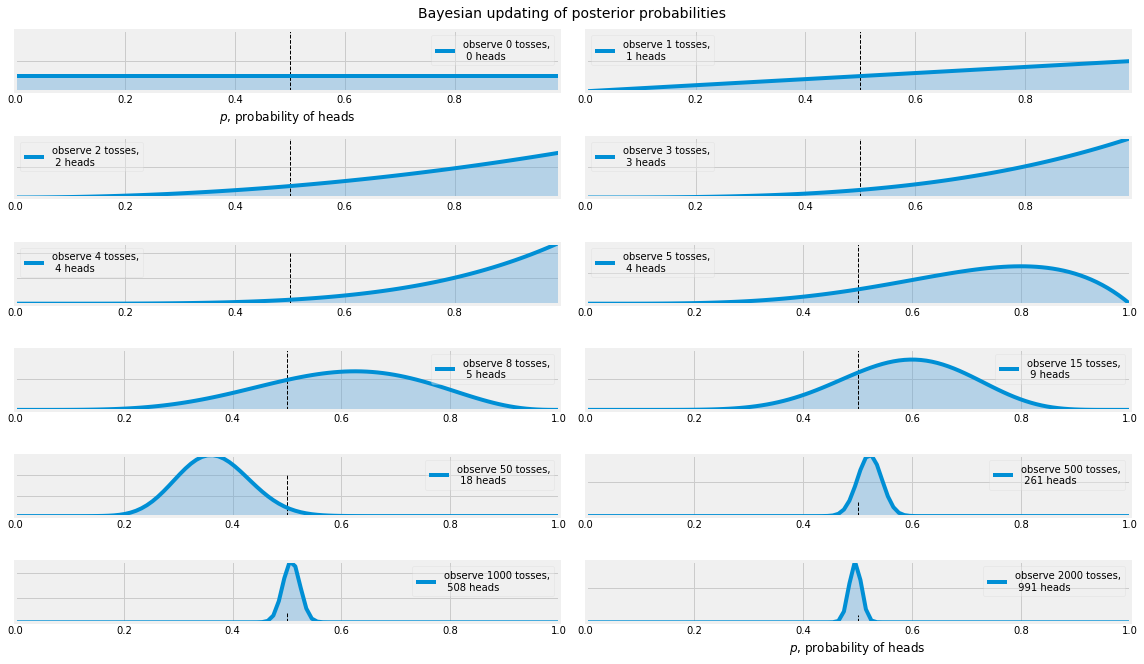

In [7]:
plt.figure(figsize(16, 9))
for i in range(len(num_trials_)):
    sx = plt.subplot(len(num_trials_)/2, 2, i+1)
    plt.xlabel("$p$, probability of heads") \
    if i in [0, len(num_trials_)-1] else None
    plt.setp(sx.get_yticklabels(), visible=False)
    plt.plot(probs_of_heads_, observed_probs_heads_[i], 
             label="observe %d tosses,\n %d heads" % (num_trials_[i], cumulative_headcounts_[i]))
    plt.fill_between(probs_of_heads_, 0, observed_probs_heads_[i], 
                     color=TFColor[3], alpha=0.4)
    plt.vlines(0.5, 0, 4, color="k", linestyles="--", lw=1)
    leg = plt.legend()
    leg.get_frame().set_alpha(0.4)
    plt.autoscale(tight=True)


plt.suptitle("Bayesian updating of posterior probabilities", y=1.02,
             fontsize=14)
plt.tight_layout()

后验概率由曲线表示，不确定性和曲线的宽度成比例，随着试验次数的增加，我们的概率会越来越接近$p=0.5$的真实值

设P(A) = p

$$
P(A|X) = \frac{P(X|A)\cdot P(A)}{P(X)} = \frac{2p}{1+p}
$$

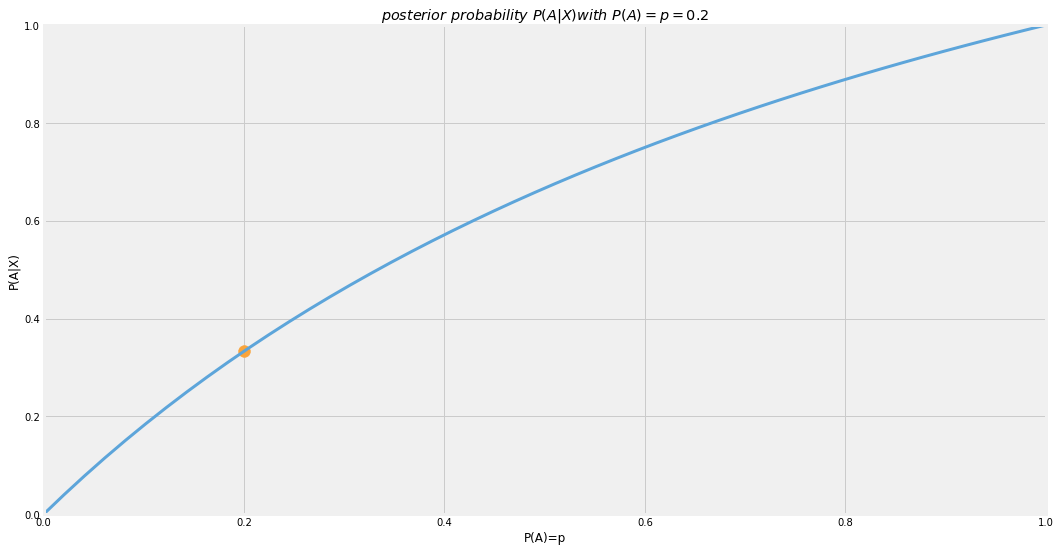

In [8]:
p = tf.lin_space(start=0., stop=1., num=50)

[p_] = evaluate([p])
f =  lambda x:2.*(x)/(x+1.)
fp_ = f(p)
plt.plot(p_, fp_, color=TFColor[3], lw="3")
plt.title(r"$posterior \ probability \ P(A|X) with \ P(A)=p=0.2$")
plt.xlim(0.,1.)
plt.ylim(0.,1.)
plt.xlabel("P(A)=p")
plt.ylabel("P(A|X)")
plt.scatter(0.2, f(0.2), s=140, c=TFColor[1])
plt.show()

In [9]:
x = tf.lin_space(start=0., stop=1., num=100)
x = tf.Variable(x, name="x")
with tf.GradientTape(watch_accessed_variables=False) as tape: 
    tape.watch(x) 
    y = tf.divide(tf.multiply(2.,x), tf.add(x,1.))  # 2x/(x+1)
gradient = tape.gradient(y, x)

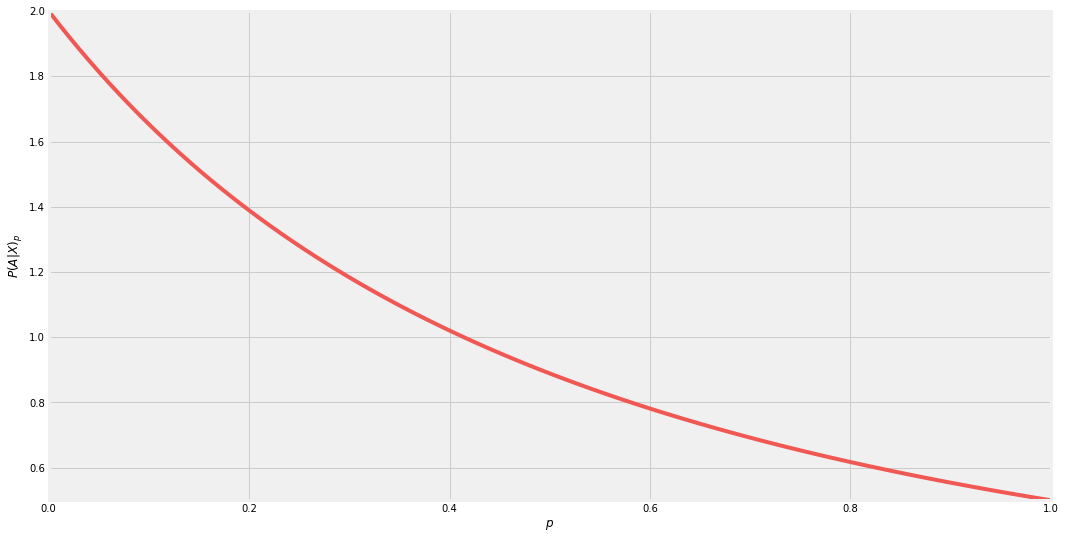

In [10]:
[x_, gradient_] = evaluate([x, gradient])

plt.plot(x_, gradient_, color=TFColor[0])
plt.xlim(0.,1.)
plt.ylim(0.5,2.)
plt.xlabel(r"$p$")
plt.ylabel(r"$P(A|X)_{p}$")
plt.show()

### poisson distribution

$$
P(Z = k) = \frac{\lambda^ke^{-\lambda}}{K!},\ k=0,1,2,\dots
$$

$$
Z \sim \mathrm{Poi}(\lambda)
$$

$$
E[Z|\lambda] = \lambda
$$

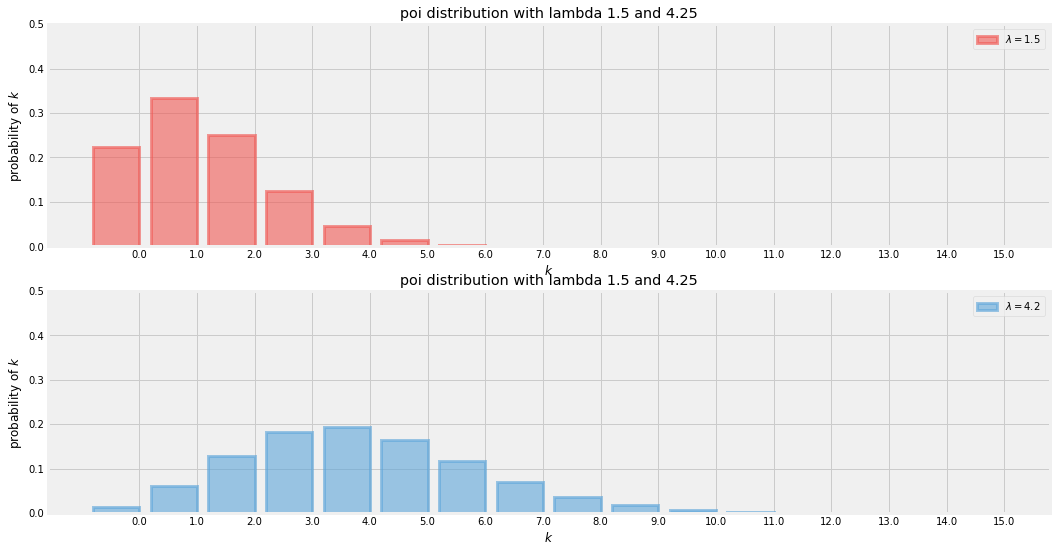

In [11]:
xrange = tf.range(start=0., limit=16.)
lambdas = tf.constant([1.5, 4.25])

poi_pmf = tfd.Poisson(rate=lambdas[:, tf.newaxis]).prob(xrange)
[xrange_, lambdas_, poi_pmf_] = evaluate([xrange, lambdas, poi_pmf])

colors = [TFColor[0], TFColor[3]]
for i in [0, 1]:
    ax = plt.subplot(2, 1, i + 1)
    ax.set_autoscaley_on(False)
    plt.title('poi distribution with lambda 1.5 and 4.25')
    
    plt.bar(xrange_, poi_pmf_[i], color=colors[i], label=r"$\lambda = %.1f$" % lambdas_[i], 
            alpha=0.60, edgecolor=colors[i], lw="3")
    plt.xticks(xrange_ + 0.4, xrange_)
    plt.ylim([0, .5])
    plt.legend()
    plt.ylabel(r"probability of $k$")
    plt.xlabel(r"$k$")

### exponential density

$$
f_Z(z|\lambda) = \lambda e^{-\lambda z}, z\geq0 
$$

$$
Z\sim \mathrm{Exp}(\lambda)
$$

$$
E[Z|\lambda] = \frac{1}{\lambda}
$$

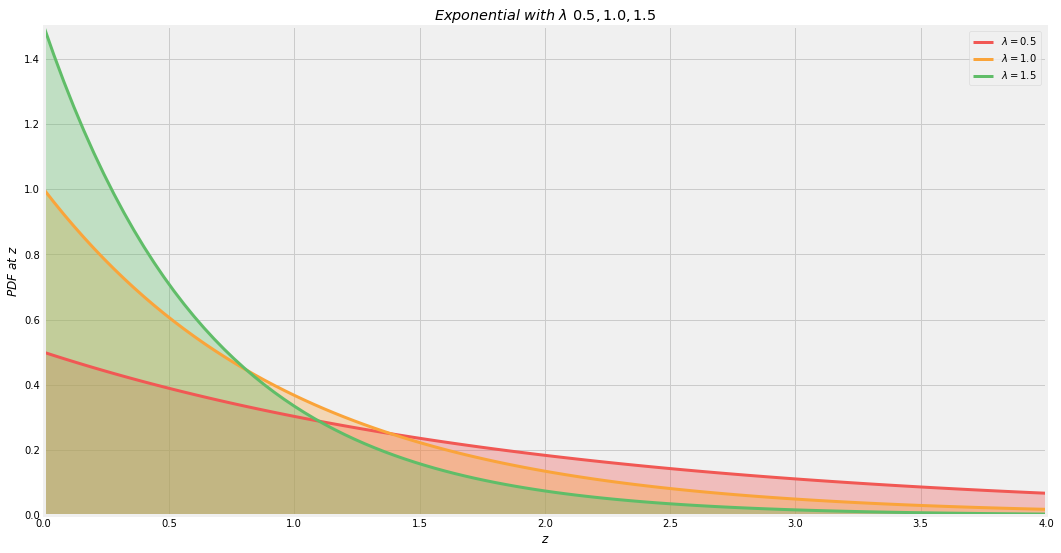

In [12]:
z = tf.range(start=0., limit=4.5, delta=0.04)
z = z[..., tf.newaxis]
lambdas = tf.constant([0.5, 1., 1.5])

expo_pdf = tfd.Exponential(rate=lambdas).prob(z)
[z_, lambdas_, expo_pdf_] = evaluate([z, lambdas, expo_pdf])

for i in range(lambdas_.size):
    plt.plot(z_.T[0], expo_pdf_.T[[i]][0],lw="3", color=TFColor[i], 
             label=r"$\lambda = %.1f$" % lambdas_[i])
    plt.fill_between(z_.T[0], expo_pdf_.T[[i]][0], color=TFColor[i], alpha=0.33)

plt.legend()
plt.xlim(0.,4.)
plt.ylim(0.,1.5)
plt.title(r'$Exponential \ with \ \lambda \ 0.5, 1.0, 1.5$')
plt.xlabel(r'$z$')
plt.ylabel(r'$PDF \ at \ z$')
plt.show()

Bayesian 推断关注的是参数的信念，而非准确的猜测参数。   
我们把概率赋给一个值，表示我们队该值的信念度

In [13]:
count_data = tf.constant([
    13,  24,   8,  24,   7,  35,  14,  11,  15,  11,  22,  22,  11,  57,  
    11,  19,  29,   6,  19,  12,  22,  12,  18,  72,  32,   9,   7,  13,  
    19,  23,  27,  20,   6,  17,  13,  10,  14,   6,  16,  15,   7,   2,  
    15,  15,  19,  70,  49,   7,  53,  22,  21,  31,  19,  11,  18,  20,  
    12,  35,  17,  23,  17,   4,   2,  31,  30,  13,  27,   0,  39,  37,   
    5,  14,  13,  22,
], dtype=tf.float32)

(-0.5, 73.5)

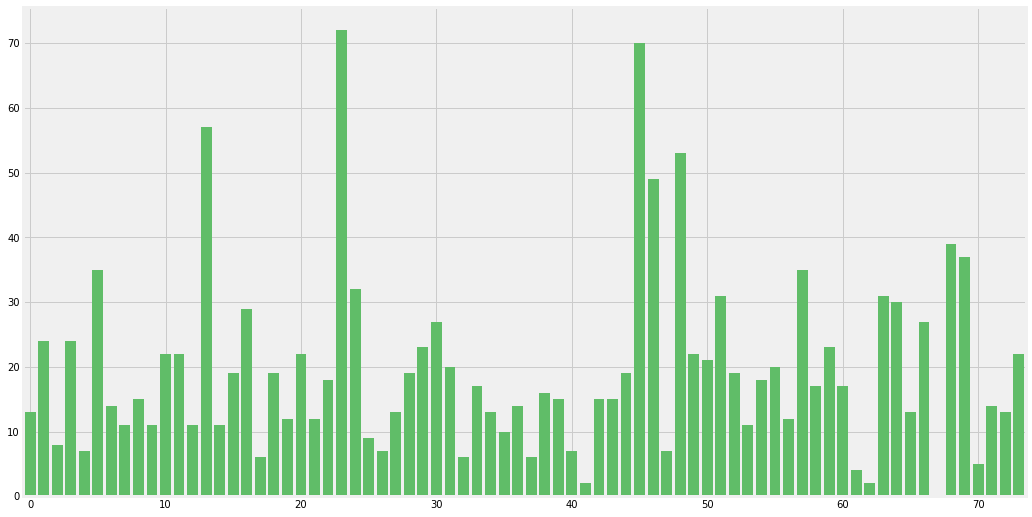

In [14]:
n_count_data = tf.shape(count_data)
days = tf.range(n_count_data[0])

[count_data_, n_count_data_, days_] = evaluate([count_data, n_count_data, days])
plt.bar(days_, count_data, color=TFColor[2], lw=3)
plt.xlim(0.-0.5,days_[-1]+0.5)

$$
C_{i} \sim \mathrm{Poi}(\lambda)
$$

$$
\frac{1}{N}\sum_{i=0}^{N}C_i \approx   E[C|\lambda]=\lambda \tag{1}
$$

对于计数类型我们可以用$\mathrm{Poi}$分布建模，观察发现用户的收发邮件量发生了突变。架设在$\tau$天发生突变 

$$
\lambda = \begin{cases}
 \lambda_1 & \text{ if } t < \tau \\
 \lambda_2 & \text{ if } t \geq \tau
\end{cases}
$$

我们使用指数分布估计泊松分布的参数，指数分布的参数为$\alpha$

$$
\begin{align*}
 \lambda_1 & \sim \mathrm{Exp}(\alpha) \\ 
 \lambda_2 & \sim \mathrm{Exp}(\alpha) 
\end{align*}
$$

$$
E[\lambda|\alpha] = \frac{1}{\alpha}
$$

为了减少$\alpha$对模型的影响，另其等于期望值，即有   
$$
\alpha^{-1} = \frac{1}{N}\sum_{i=0}^NC_i
$$

In [16]:
def joint_log_prob(count_data, lambda_1, lambda_2, tau):
    tfd = tfp.distributions
    alpha = np.array(1. / count_data.mean(), np.float32)
    rv_lambda_1 = tfd.Exponential(rate=alpha)
    rv_lambda_2 = tfd.Exponential(rate=alpha)
    
    rv_tau = tfd.Uniform()
    
    lambda_ = tf.gather(
        params=[lambda_1, lambda_2],
        indices=tf.to_int32(tau + count_data.size <= np.arange(count_data.size)))
    rv_observation = tfd.Poisson(rate=lambda_)
    return (
        rv_lambda_1.log_prob(lambda_1) + 
        rv.lambda_2.log_prob(lambda_2) + 
        rv_tau.log_prob(tau) + 
        tf.reduce_sum(rv_observation.log_prob(count_data))
    )